In [8]:
import fastf1 as ff1
import pandas as pd
from DB.models import Circuit, RacingWeekend, Driver, Session, SessionResult, init_db


In [9]:
engine, db_session = init_db()

session = (
	db_session.query(Session)
	.join(RacingWeekend, Session.weekend_id == RacingWeekend.racing_weekend_id)
	.filter(
		RacingWeekend.year == 2024,
		RacingWeekend.round == 1,
		Session.session_type == "Race"
	)
	.first()
)

laps_data = []
for lap in session.laps:

	# add a row for each sector
	laps_data.append({
		"lap_num": lap.lap_num,
		"lap_time": lap.lap_time,
		"stint_num": lap.stint_num,
		"stint_lap": lap.stint_lap,
		"position": lap.position,
		"driver_name": lap.driver.driver_name,
		"driver_number": lap.driver.driver_num,
		"lap_time": lap.lap_time,
		
		"sector1_time": lap.s1_time,
		"sector2_time": lap.s2_time,
		"sector3_time": lap.s3_time,

		"tyre_type": lap.tyre_type,
		"tyre_laps": lap.tyre_laps,
		"pit": lap.pit,
		"pit_time": lap.pit_stop[0].pit_time if lap.pit_stop else None,
		"track_status": lap.track_status,
	})

race_df = pd.DataFrame(laps_data)



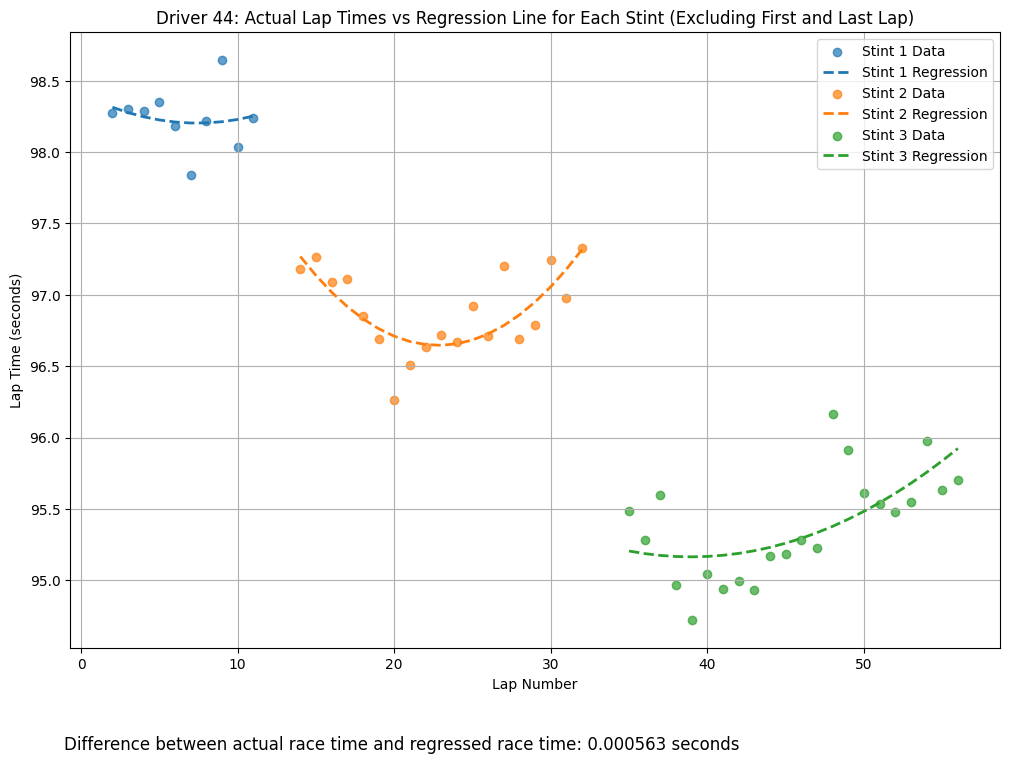

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

driver_data = race_df[race_df["driver_number"] == 44]

grouped_by_stint = driver_data.groupby("stint_num")

plt.figure(figsize=(12, 8))

colors = plt.cm.tab10.colors

actual_total_race_time = 0
regression_total_race_time = 0

# fit regression models for each stint and plot
for i, (stint_num, stint_data) in enumerate(grouped_by_stint):
    # exclude the first and last lap
    filtered_data = stint_data.iloc[1:-1]
    
    if filtered_data.empty:
        print(f"Stint {stint_num}: Not enough data after excluding first and last lap.")
        continue

    x = filtered_data["lap_num"].values
    y = filtered_data["lap_time"].values

    # Define the objective function for least squares
    def objective(coeffs):
        a, b, c = coeffs
        return np.sum((a * x**2 + b * x + c - y)**2)

    # Define constraints
    constraints = (
        {"type": "ineq", "fun": lambda coeffs: coeffs[0]},  # Ensure a >= 0
    )

    # Initial guess for coefficients
    initial_guess = [0.001, 0.1, y[0]]  # Small positive values for [a, b, c]

    result = minimize(objective, initial_guess, constraints=constraints)
    a, b, c = result.x

    y_pred = a * x**2 + b * x + c

    actual_total_race_time += np.sum(y)
    regression_total_race_time += np.sum(y_pred) 
    
    # Plot the actual lap times and regression line for this stint
    plt.scatter(x, y, color=colors[i % len(colors)], label=f"Stint {stint_num} Data", alpha=0.7)
    plt.plot(x, y_pred, color=colors[i % len(colors)], linestyle="--", label=f"Stint {stint_num} Regression", linewidth=2)

    
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.title("Driver 44: Actual Lap Times vs Regression Line for Each Stint (Excluding First and Last Lap)")
plt.legend()
plt.grid(True)


plt.figtext(
    0.12,
    0,
    f"Difference between actual race time and regressed race time: {actual_total_race_time - regression_total_race_time:.6f} seconds",
    fontsize=12,
    color="black",
    ha="left",
    va="top"
)

plt.show()

# print(f"Difference between actual race time and regressed race time: {actual_total_race_time - regression_total_race_time:.6f} seconds ")
